# Lab 02 - Multi-Objective Optimization
## Tasks
- Learn to solve optimization problems using the Xopt package
- Conduct multi-objective optimization on AWA photoinjector example

## Set up environment

In [2]:
!pip install xopt==2.5.2
!pip install pygmo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.3/915.3 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB

In [16]:
%reset -f
from google.colab import drive
import os

drive.mount('/content/drive')
path = '/content/drive/MyDrive/optimization_and_ml/labs/lab_02_multi_objective_optimization'
os.chdir(path)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
awa_model.pt  Figure5.png  lab_02.ipynb


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import xopt

import torch

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Multi-objective optimization of a test problem


Our goal is to find the ideal trade-off between two objectives $f_1,f_2$. We will use a problem selected from a collection of test problems known as the ZDT problem suite. The following explaination is from (https://github.com/anyoptimization/pymoo/blob/main/docs/source/problems/multi/zdt.ipynb) which discusses the entire collection.

### ZDT

The ZDT <cite data-cite="zdt"></cite> problem suite is based on the construction process

\begin{align}
\begin{split}
\min && \; f_1(x)\\
\min && \; f_2(x) = g(x) \, h(f_1(x),g(x))
\end{split}
\end{align}

where two objective have to be minimized. The function $g(x)$ can be considered as the function for convergenece  and usually $g(x) = 1$ holds for pareto-optimal solutions (except for ZDT5).

### ZDT1

This is a n-D variable problem (here we will use $n=10$) with a convex Pareto-optimal set:

**Definition**

\begin{align}
\begin{split}
f_1(x) &= \, & x_1 \\
g(x) &=& 1 + \frac{9}{n-1} \; \sum_{i=2}^{n} x_i \\
h(f_1,g) &=& 1 - \sqrt{f_1/g} \\
\end{split}
\end{align}


$$0 \leq x_i \leq 1 \quad i=1,\ldots,n$$

**Optimum**

$$0 \leq x_1^* \leq 1  \quad \text{and} \quad x_i^*=0 \; \text{for} \; i=2,\ldots,n$$


To solve this problem we will use the evolutionary CNSGA algorithm, implmented in Xopt.

## Defining the problem in Xopt

Xopt can interface with arbitrary evaluate functions (defined in Python) with the
following form:
```python
def evaluate(inputs: dict) -> dict:
    """ your code here """
```
Evaluate functions must accept a dictionary object that **at least** has the keys
specified in `variables, constants` and returns a dictionary
containing **at least** the
keys contained in `objectives, constraints`. Extra dictionary keys are tracked and
used in the evaluate function but are not modified by xopt.

In [66]:
from xopt import Evaluator

# define the problem as a python callable
n_dims = 10
def evaluate(input_dict):
    x = np.array([input_dict[f"x{i + 1}"] for i in range(n_dims)])

    f1 = x[0]
    g = 1 + (9 / (n_dims - 1)) * np.sum(x[1:])
    h = 1 - np.sqrt(f1 / g)
    f2 = g * h

    return {"f1": f1, "f2": f2, "g": g}

evaluator = Evaluator(function=evaluate)

## Define the variables and objectives
Next we define the variables and objectives for our problem in a `VOCS` object.

In [67]:
from xopt import VOCS
vocs = VOCS(
    variables={f"x{i + 1}": [0, 1] for i in range(n_dims)},
    objectives={"f1": "MINIMIZE", "f2": "MINIMIZE"},
)
vocs.model_dump()

{'variables': {'x1': [0.0, 1.0],
  'x2': [0.0, 1.0],
  'x3': [0.0, 1.0],
  'x4': [0.0, 1.0],
  'x5': [0.0, 1.0],
  'x6': [0.0, 1.0],
  'x7': [0.0, 1.0],
  'x8': [0.0, 1.0],
  'x9': [0.0, 1.0],
  'x10': [0.0, 1.0]},
 'constraints': {},
 'objectives': {'f1': 'MINIMIZE', 'f2': 'MINIMIZE'},
 'constants': {},
 'observables': []}

## Define the optimization algorithm

In [68]:
from xopt.generators.ga import CNSGAGenerator
generator = CNSGAGenerator(
    vocs=vocs,
    population_size=64,
    crossover_probability=0.75,
    mutation_probability=0.25
)
generator.model_dump()

{'population_size': 64,
 'crossover_probability': 0.75,
 'mutation_probability': 0.25,
 'population_file': None,
 'output_path': None,
 'population': None}

## Combine the evaluator, vocs, and generator objects into the Xopt object

In [69]:
from xopt import Xopt
X = Xopt(
    vocs=vocs,
    generator=generator,
    evaluator=evaluator
)

In [70]:
generations = 100
for _ in range(64 * generations):
    X.step()

<Axes: xlabel='f1', ylabel='f2'>

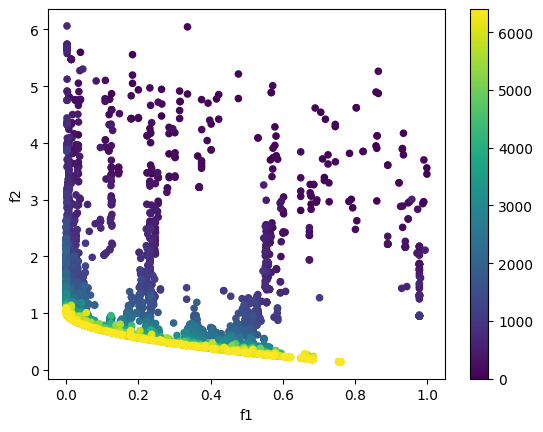

In [71]:
X.data.plot.scatter(x="f1",y="f2",c=X.data.index,cmap="viridis")

> ### **Task**
> Plot the Pareto front and calculate the front hypervolume with the reference point (11,11). See `fast_non_dominated_sorting` in https://esa.github.io/pygmo2/tutorials/moo.html and `hypervolume` in https://esa.github.io/pygmo2/tutorials/hypervolume.html .

In [72]:
##### BEGIN SOLUTION

<Axes: xlabel='f1', ylabel='f2'>

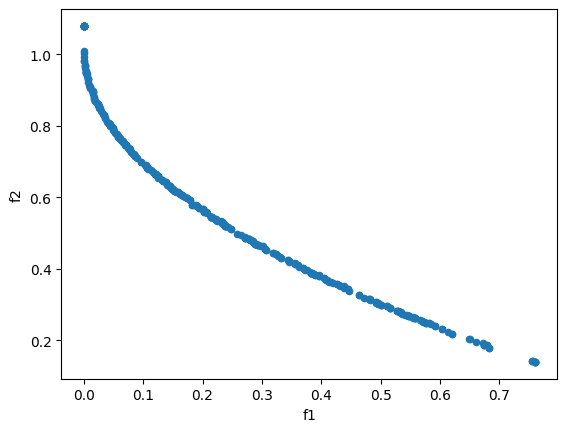

In [73]:
# plot pareto front
from pygmo import fast_non_dominated_sorting
ndf, dl, dc, ndr = fast_non_dominated_sorting(X.data[['f1', 'f2']].to_numpy())
pareto_ids = ndf[0]
X.data.iloc[pareto_ids].plot.scatter(x="f1",y="f2")

In [74]:
# compute hypervolume
from pygmo import hypervolume
hv = hypervolume(X.data.iloc[pareto_ids][['f1', 'f2']].to_numpy())
ref_point = [11,11]
hv.compute(ref_point)

119.24633481279537

In [31]:
##### END SOLUTION

# Multi-objective optimization of the AWA photoinjector


Here we will find the pareto front of the AWA photoinjector problem (see below).
Input variables are shown in red and output variables are shown in blue. Both the
inputs and outputs are normalized to [-1,1]. Our goal is to minimize all of the
output beam parameters. To model the AWA beamline dynamics we use a pre-compiled, fast
executing neural network surrogate model (that you will have a chance to build in lab
 5!). The inputs to this model are `[P0, P1, G0, G1, K1, K2]` and the outputs are
 `[rms_x, rms_y, rms_s, emit_x, emit_y, emit_s, dE]`.



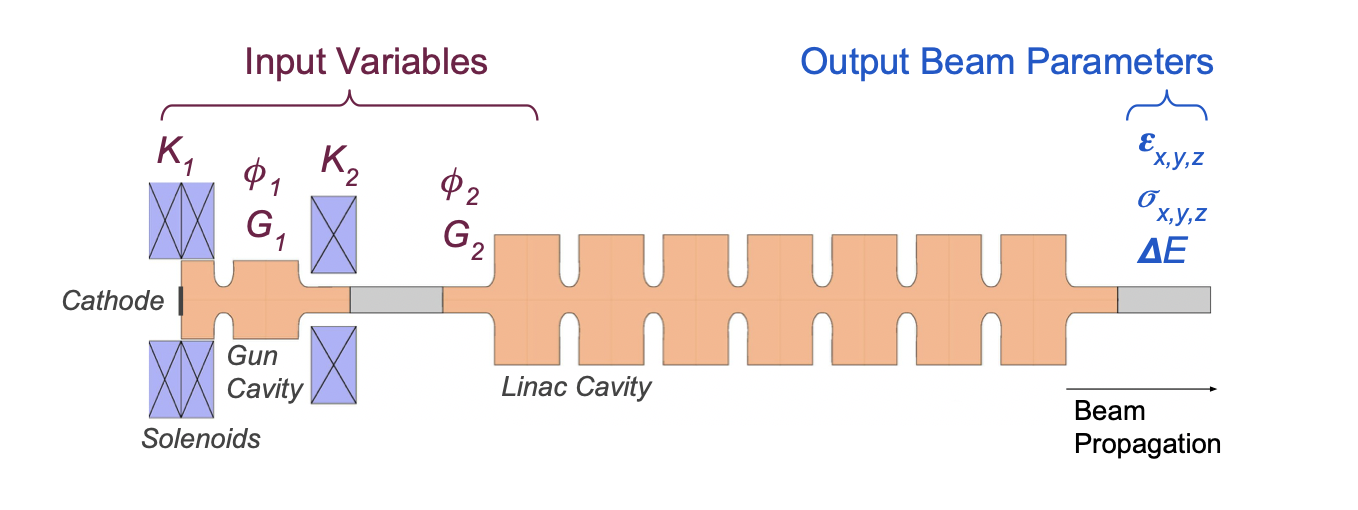

In [32]:
# get AWA model
awa_model = torch.jit.load("awa_model.pt")

# test awa_model
x = torch.rand(6)
awa_model(x)

tensor([-0.8912, -0.8628, -0.5625, -0.7406, -0.7252, -0.6169,  0.4006],
       grad_fn=<TanhBackward0>)

In [34]:
# define variables and objectives in VOCS object
awa_vocs = VOCS(
    variables={
        'P0':[-1.0,1.0],
        'P1':[-1.0,1.0],
        'G0':[-1.0,1.0],
        'G1':[-1.0,1.0],
        'K1':[-1.0,1.0],
        'K2':[-1.0,1.0]
    },
    objectives={
        'rms_x':"MINIMIZE",
        'rms_y':"MINIMIZE",
        'rms_s':"MINIMIZE",
        'emit_x':"MINIMIZE",
        'emit_y':"MINIMIZE",
        'emit_s':"MINIMIZE",
        'dE':"MINIMIZE"
    }
)

> ### **Task**
> Use the above code to find the 7D pareto front of the AWA multi-objective problem. Plot the front projected onto the bunch length vs. horizontal emittance subspace.

> Note: when evaluating the NN model, you should call `detach().numpy()` to convert the output of the model into a numpy array.

In [35]:
##### BEGIN SOLUTION

In [36]:
# define Xopt generator
awa_generator = CNSGAGenerator(
    vocs=awa_vocs,
    population_size=64,
    crossover_probability=0.75,
    mutation_probability=0.25
)

# define evaluation function
def awa_function(input_dict):
    x = torch.tensor(
        [
            input_dict['P0'],
            input_dict['P1'],
            input_dict['G0'],
            input_dict['G1'],
            input_dict['K1'],
            input_dict['K2']
        ]
        )
    out = awa_model(x).detach().numpy()
    return {
        'rms_x': out[0],
        'rms_y': out[1],
        'rms_s': out[2],
        'emit_x': out[3],
        'emit_y': out[4],
        'emit_s': out[5],
        'dE': out[6]
        }

# define Xopt evaluator
awa_evaluator = Evaluator(function=awa_function)

# define Xopt object
X_awa = Xopt(
    vocs = awa_vocs,
    generator = awa_generator,
    evaluator = awa_evaluator
)

In [37]:
# check Xopt object
X_awa


            Xopt
________________________________
Version: 2.5.2
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.awa_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.75
  mutation_probability: 0.25
  name: cnsga
  output_path: null
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constraints: {}
  objectives:
    dE: MINIMIZE
    emit_s: MINIMIZE
    emit_x: MINIMIZE
    emit_y: MINIMIZE
    rms_s: MINIMIZE
    rms_x: MINIMIZE
    rms_y: MINIMIZE
  observables: []
  variables:
    G0:
    - -1.0
    - 1.0
    G1:
    - -1.0
    - 1.0
    K1:
    - -1.0
    - 1.0
    K2:
    - -1.0
    - 1.0
    P0:
    - -1.0
    - 1.0
    P1:
    - -1.0
    - 1.0


In [38]:
# test a random evaluation point before optimizing
X_awa.random_evaluate(1)

,P0,P1,G0,G1,K1,K2,rms_x,rms_y,rms_s,emit_x,emit_y,emit_s,dE,xopt_runtime,xopt_error
0,-0.740772,0.982464,0.31346,0.135626,-0.274756,0.066708,-0.354937,-0.373334,-0.71934,-0.621047,-0.626811,-0.843231,-0.343012,0.011975,False


In [39]:
# run optimization
generations = 100
for _ in range(64 * generations):
    X_awa.step()

<Axes: xlabel='rms_s', ylabel='emit_x'>

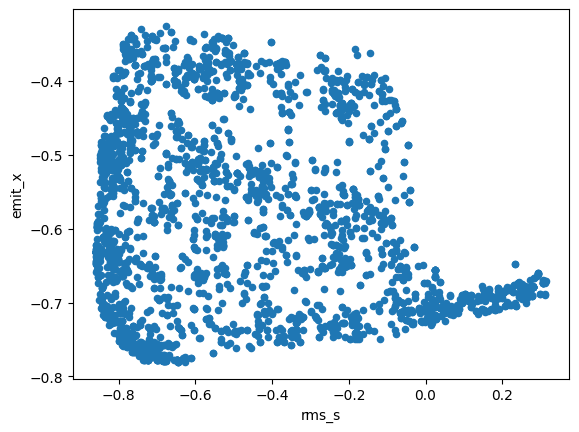

In [40]:
# find Pareto front in 7D objective space
ndf, dl, dc, ndr = fast_non_dominated_sorting(X_awa.data[X_awa.vocs.objective_names].to_numpy())
pareto_ids = ndf[0]

# plot Pareto front projected onto bunch length and horizontal emittance
X_awa.data.iloc[pareto_ids].plot.scatter(x="rms_s",y="emit_x")

In [41]:
##### END SOLUTION

# **Homework**
Another approach to solving multi-objective problems is to specify explicit weights that rate the relative importance of each objective. In this case the problem is single objective and can be solved by a variety of single objective algorithms, including RCDS. Use the Xopt `RCDSGenerator` generator (see https://xopt.xopt.org/examples/rcds/rcds/ for an example) to solve for multiple different objective trade-offs of the ZDT1 problem
- even weighting between all objectives
- weight `f1 = 2*f2` with all others equal weighting with respect to rms_s
- weight `f2 = 2*f1` with all others equal weighting with respect to rms_s

Plot the `f1,f2` function values found to minimize the three problems on an axis that also contains the ZDT1 pareto front. How do these solutions compare to the Pareto front in objective space?

In [95]:
from xopt.generators.rcds.rcds import RCDSGenerator
### SOLUTION


from xopt import VOCS
vocs = VOCS(
    variables={f"x{i + 1}": [0, 1] for i in range(n_dims)},
    objectives={"obj": "MINIMIZE"},
)

from xopt import Evaluator

# define the problem as a python callable
n_dims = 10
def evaluate(input_dict):
    x = np.array([input_dict[f"x{i + 1}"] for i in range(n_dims)])

    f1 = x[0]
    g = 1 + (9 / (n_dims - 1)) * np.sum(x[1:])
    h = 1 - np.sqrt(f1 / g)
    f2 = g * h

    return {"f1": f1, "f2": f2, "g": g, "obj":f1 + 2*f2}

evaluator = Evaluator(function=evaluate)

generator = RCDSGenerator(vocs=vocs)

X_rcds = Xopt(
    vocs = vocs,
    generator = generator,
    evaluator = evaluator
)

X_rcds.random_evaluate(1)

for i in range(300):
  X_rcds.step()

In [96]:
X_rcds.data.iloc[-1]

,300
x1,0.991509
x2,0.002491
x3,0.002491
x4,0.002491
x5,0.002491
x6,0.002491
x7,0.002491
x8,0.006491
x9,0.000491
x10,0.002491


<Axes: xlabel='f1', ylabel='f2'>

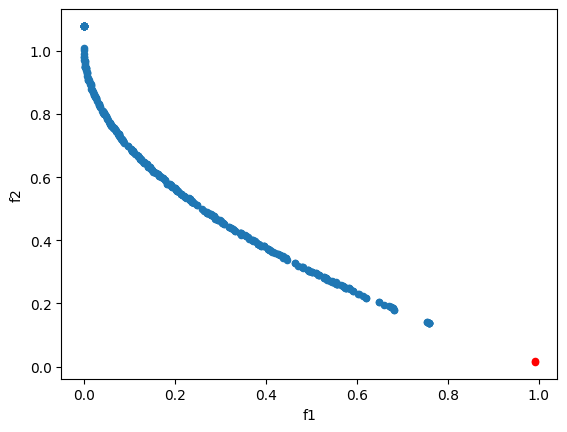

In [97]:
ndf, dl, dc, ndr = fast_non_dominated_sorting(X.data[['f1', 'f2']].to_numpy())
pareto_ids = ndf[0]
ax = X.data.iloc[pareto_ids].plot.scatter(x="f1",y="f2")

X_rcds.data.iloc[-2:].plot.scatter(x="f1",y="f2",ax=ax, color='red')

<Axes: >

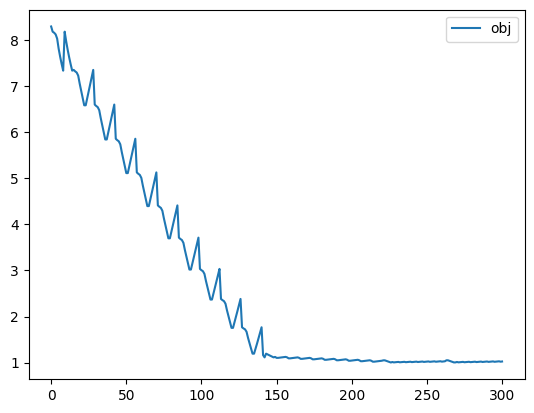

In [98]:
X_rcds.data.plot(y=["obj"])